In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
y = """112  115  145  171  196  204  242  284  315  340  360  417    
     118  126  150  180  196  188  233  277  301  318  342  391    
     132  141  178  193  236  235  267  317  356  362  406  419    
     129  135  163  181  235  227  269  313  348  348  396  461   
     121  125  172  183  229  234  270  318  355  363  420  472    
     135  149  178  218  243  264  315  374  422  435  472  535    
     148  170  199  230  264  302  364  413  465  491  548  622    
     148  170  199  242  272  293  347  405  467  505  559  606    
     136  158  184  209  237  259  312  355  404  404  463  508    
     119  133  162  191  211  229  274  306  347  359  407  461    
     104  114  146  172  180  203  237  271  305  310  362  390    
     118  140  166  194  201  229  278  306  336  337  405  432 """

In [3]:
y=y.replace("  ",",").replace('\n,,','').replace(' ','').replace(',,',',')
y=[float(x) for x in y.split(',')]

y=np.asarray(y).reshape(12,12).transpose()

ts=pd.DataFrame(y.reshape(144,1))

In [4]:
rng = pd.date_range(start='1949', periods=144, freq='M')
#ts = pd.Series(y, index=rng)
ts.index=rng

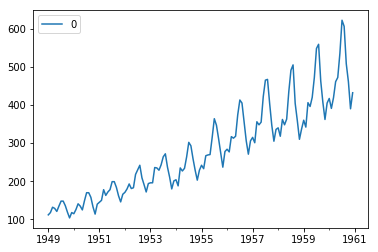

In [5]:
ts.plot()

# RNN

In [177]:
ts = np.array(ts)
n_windows = 20   
n_input =  1
n_output = 1
train=ts[:101]
test=ts[104:]

In [178]:
def create_batches(df, n_windows, n_input, output):
    ## Create X         
        x_data = train[:100] # Select the data
        X_batches = x_data.reshape(-1, n_windows, n_input)  # Reshape the data 
    ## Create y
        y_data = train[n_output:101]
        y_batches = y_data.reshape(-1, n_windows, n_output)
        return X_batches, y_batches

In [179]:
x_batch, y_batch = create_batches(df = train,n_windows = n_windows,n_input = n_input,output = n_output)

In [180]:
x_batch.shape

(5, 20, 1)

In [181]:
tf.reset_default_graph()  #clean computational graph

## 1. Construct the tensors
x = tf.placeholder("float", [None, n_windows, n_input])   
y = tf.placeholder("float", [None, n_windows, n_output])

## 2. create the model
basic_cell = tf.nn.rnn_cell.BasicRNNCell(num_units=120, activation=tf.nn.relu)   
rnn_output, states = tf.nn.dynamic_rnn(basic_cell, x, dtype=tf.float32)   
# dynamic_rnn allow variable length input, static_runn only take fixed length input 

stacked_rnn_output = tf.reshape(rnn_output, [-1, 120])          
stacked_outputs = tf.layers.dense(inputs=stacked_rnn_output, units=n_output)       
outputs = tf.reshape(stacked_outputs, [-1, n_windows, n_output])   

## 3. Loss + optimization 
 
loss = tf.reduce_sum(tf.square(outputs - y))    
model = tf.train.AdamOptimizer(learning_rate=0.01).minimize(loss)        
                                         


In [183]:
init = tf.global_variables_initializer() 

avg_cost=[]

with tf.Session() as session:
    session.run(init)
    for i in range(500):
        session.run(model,feed_dict={x:x_batch,y:y_batch})
        avg_cost.append(session.run(loss,feed_dict={x:x_batch,y:y_batch}))
    y_pred = session.run(outputs, feed_dict={x:test.reshape(2,20,1)})

        

# RNN with LSTM

In [267]:
tf.reset_default_graph() 
x = tf.placeholder("float", [None, n_windows, n_input])   
y = tf.placeholder("float", [None, n_windows, n_output])

lstm_cell = tf.nn.rnn_cell.BasicLSTMCell(num_units=120, activation=tf.nn.relu) #forget_bias=1,  
rnn_output2, states2 = tf.nn.dynamic_rnn(lstm_cell, x, dtype=tf.float32)   
# dynamic_rnn allow variable length input, static_runn only take fixed length input 

stacked_rnn_output2 = tf.reshape(rnn_output2, [-1, 120])          
stacked_outputs2 = tf.layers.dense(inputs=stacked_rnn_output2, units=n_output)       
outputs2 = tf.reshape(stacked_outputs2, [-1, n_windows, n_output])   

## 3. Loss + optimization 
 
loss2 = tf.reduce_sum(tf.square(outputs2 - y))    
model2 = tf.train.AdamOptimizer(learning_rate=0.01).minimize(loss2)        

In [268]:
init = tf.global_variables_initializer() 

avg_cost2=[]

with tf.Session() as session:
    session.run(init)
    for i in range(500):
        session.run(model2,feed_dict={x:x_batch,y:y_batch})
        avg_cost2.append(session.run(loss2,feed_dict={x:x_batch,y:y_batch}))
    y_pred2 = session.run(outputs2, feed_dict={x:test.reshape(2,20,1)})

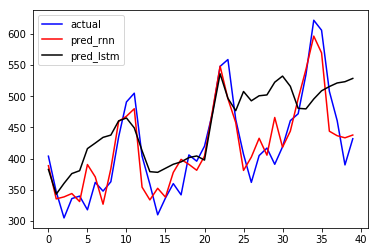

In [269]:
plt.plot(pd.Series(np.ravel(test)),color='blue',label='actual')
plt.plot(pd.Series(np.ravel(y_pred)),color='red',label='pred_rnn')
plt.plot(pd.Series(np.ravel(y_pred2)),color='black',label='pred_lstm')
plt.legend()
plt.show()

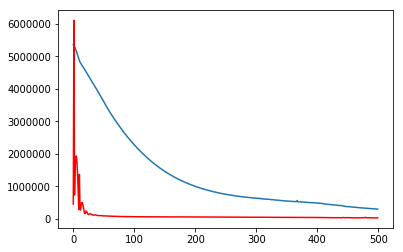

In [199]:
plt.plot(avg_cost2)
plt.plot(avg_cost,color='red')

# Keras LSTM

In [24]:
from keras.models import Sequential 
from keras.layers import Dense,LSTM

In [96]:
def create_dataset(df,look_back=20):
    x=[]
    y=[]
    for i in range(df.shape[0]-look_back-1):
        x.append(df[i:i+look_back])
        y.append(df[i+look_back])
    return np.asarray(x),np.asarray(y)

In [97]:
train_x,train_y=create_dataset(np.ravel(np.array(ts[:100])))
test_x,test_y=create_dataset(np.ravel(np.array(ts[100:])))

In [98]:
train_x=train_x.reshape(-1,1,20)
test_x=test_x.reshape(-1,1,20)

In [114]:
with tf.Session() as session:
    model = Sequential()
    model.add(LSTM(64, input_shape=(1,20),activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    model.fit(train_x, train_y, epochs=100, batch_size=1, verbose=1)
    pred=model.predict(test_x)

Epoch 1/100
79/79 [==============================] - 2s 19ms/step - loss: 19703.9696
Epoch 2/100
79/79 [==============================] - 0s 1ms/step - loss: 1590.2974
Epoch 3/100
79/79 [==============================] - 0s 1ms/step - loss: 1485.3172
Epoch 4/100
79/79 [==============================] - 0s 1ms/step - loss: 1478.4192
Epoch 5/100
79/79 [==============================] - 0s 1ms/step - loss: 1349.0818
Epoch 6/100
79/79 [==============================] - 0s 1ms/step - loss: 1320.9555
Epoch 7/100
79/79 [==============================] - 0s 1ms/step - loss: 1279.1621
Epoch 8/100
79/79 [==============================] - 0s 1ms/step - loss: 1161.8858
Epoch 9/100
79/79 [==============================] - 0s 1ms/step - loss: 1253.7113
Epoch 10/100
79/79 [==============================] - 0s 1ms/step - loss: 1157.7589
Epoch 11/100
79/79 [==============================] - 0s 1ms/step - loss: 1203.9320
Epoch 12/100
79/79 [==============================] - 0s 1ms/step - loss: 1066.3703

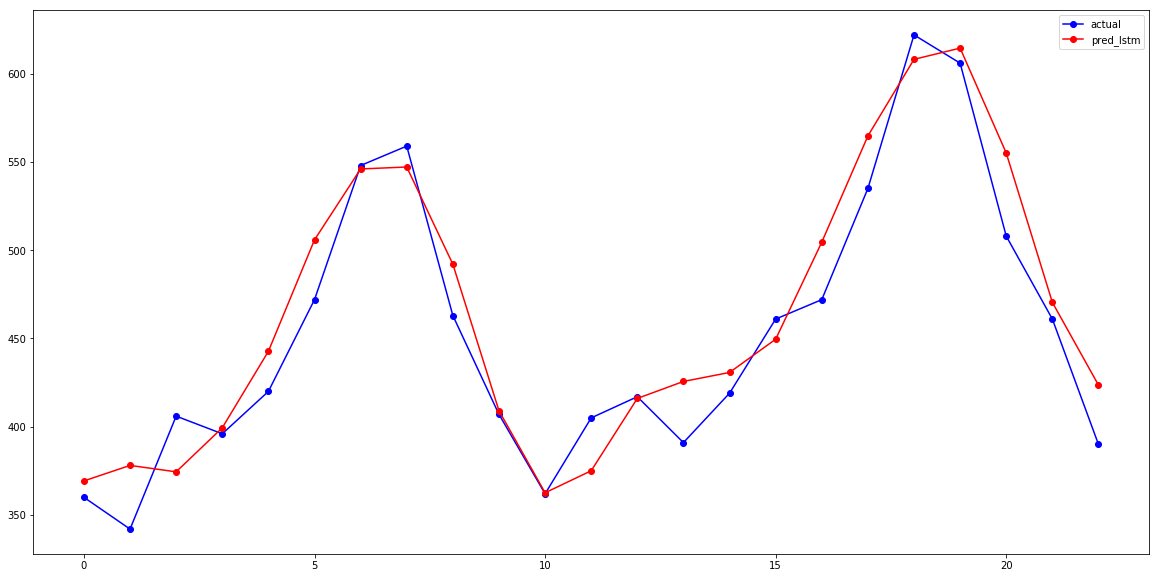

In [115]:
plt.figure(figsize=(20,10))
plt.plot(test_y,color='blue',label='actual',marker='o')
plt.plot(pred,color='red',label='pred_lstm',marker='o')
plt.legend()
plt.show()

# Keras GRU

In [8]:
from keras.layers import Dense, GRU
from keras.models import Sequential 

In [110]:
#tf.reset_default_graph()
with tf.Session() as session:
    model2 = Sequential()
    model2.add(GRU(20, input_shape=(1,20),activation='relu'))
    model2.add(Dense(1))
    model2.compile(loss='mse', optimizer='adam')
    model2.fit(train_x, train_y, epochs=100, batch_size=1, verbose=1)
    pred2=model2.predict(test_x)

Epoch 1/100
79/79 [==============================] - 1s 16ms/step - loss: 16954.2517
Epoch 2/100
79/79 [==============================] - 0s 1ms/step - loss: 1662.0144
Epoch 3/100
79/79 [==============================] - 0s 1ms/step - loss: 1440.1870
Epoch 4/100
79/79 [==============================] - 0s 987us/step - loss: 1240.2045
Epoch 5/100
79/79 [==============================] - 0s 1ms/step - loss: 1121.9234
Epoch 6/100
79/79 [==============================] - 0s 1ms/step - loss: 1044.7372
Epoch 7/100
79/79 [==============================] - 0s 987us/step - loss: 1073.5417
Epoch 8/100
79/79 [==============================] - 0s 1ms/step - loss: 987.1433
Epoch 9/100
79/79 [==============================] - 0s 1ms/step - loss: 965.8836
Epoch 10/100
79/79 [==============================] - 0s 987us/step - loss: 913.4117
Epoch 11/100
79/79 [==============================] - 0s 987us/step - loss: 900.8178
Epoch 12/100
79/79 [==============================] - 0s 1ms/step - loss: 935.6

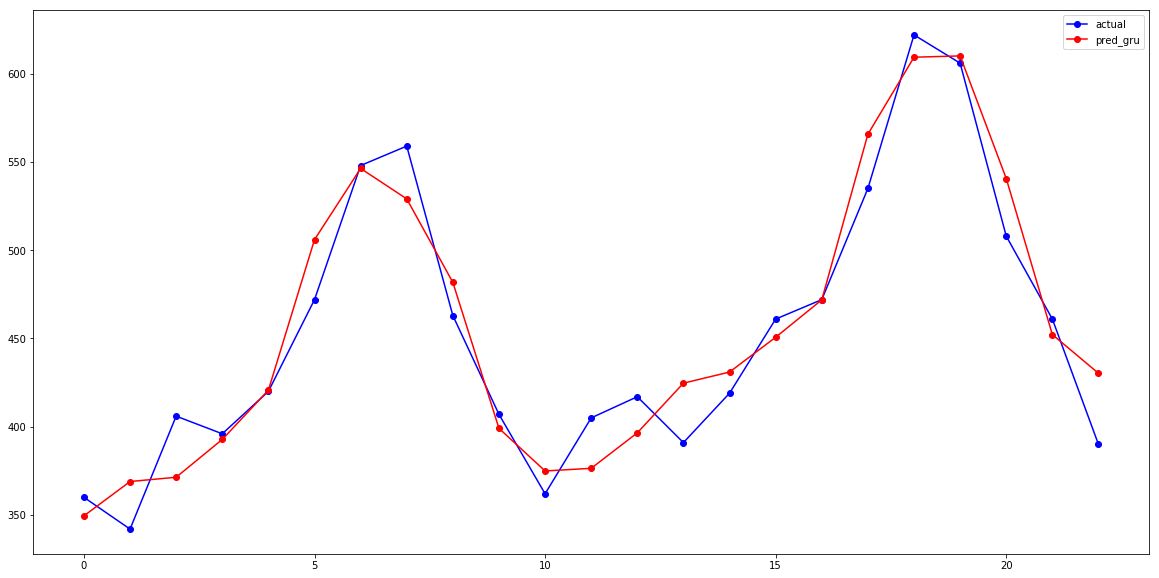

In [113]:
plt.figure(figsize=(20,10))
plt.plot(test_y,color='blue',label='actual',marker='o')
plt.plot(pred2,color='red',label='pred_gru',marker='o')
plt.legend()
plt.show()